# Análise de Absentismo - Call Center

**Objetivo:** Análise descritiva e prescritiva de padrões de absentismo.

**Dataset:** 1.3M registos, 3,135 colaboradores, 18 meses (2024-01 a 2025-06)

---

## 5. BRADFORD FACTOR ANALYSIS

**Bradford Factor** = S² × D
- S = Número de spells (episódios)
- D = Total de dias ausentes

**Princípio**: Ausências curtas e frequentes são **mais disruptivas** que ausências longas ocasionais.

**Exemplo**:
- Colaborador A: 1 spell de 10 dias → B = 1² × 10 = **10**
- Colaborador B: 10 spells de 1 dia → B = 10² × 10 = **1000** (100x pior!)

**Thresholds típicos** (Call Centre Helper):
- < 45: Aceitável
- 45-100: Conversa informal  
- 100-200: Revisão formal
- 200-500: Aviso escrito
- 500-900: Ação disciplinar
- \> 900: Preocupação séria

### 5.1: Preparar dados: Apenas 2025, Ativos, Short-Term

In [94]:
# Filtrar colaboradores ativos em 2025
colaboradores_ativos_2025 = df_base_absentismo[
    (df_base_absentismo['Activo?'] == 'Sim') &
    (df_base_absentismo['Data'].dt.year == 2025)
]['login_colaborador'].unique()

print(f'\nColaboradores ativos em 2025: {len(colaboradores_ativos_2025):,}')

# Filtrar spells: apenas short-term (<=3 dias) de colaboradores ativos
df_spells_disruptivos = df_spells[
    (df_spells['short_term'] == True) &
    (df_spells['login_colaborador'].isin(colaboradores_ativos_2025)) &
    (df_spells['data_inicio'].dt.year == 2025)
].copy()

print(f'Spells short-term em 2025 (colaboradores ativos): {len(df_spells_disruptivos):,}')

# Agregar por colaborador
df_bradford_disruptivo = df_spells_disruptivos.groupby('login_colaborador').agg({
    'spell_id': 'count',  # S = número de spells
    'duracao_dias': 'sum',  # D = total de dias
    'nome_colaborador': 'first',
    'categoria_profissional': 'first'
}).reset_index()

df_bradford_disruptivo.columns = [
    'login_colaborador', 'num_spells_short', 'total_dias_short',
    'nome_colaborador', 'categoria_profissional'
]

# Calcular Bradford Factor Disruptivo
# Bradford = S² × D
df_bradford_disruptivo['bradford_disruptivo'] = (
    df_bradford_disruptivo['num_spells_short'] ** 2
) * df_bradford_disruptivo['total_dias_short']

# Categorizar por risk level
def categorizar_bradford(score):
    if score < 50:
        return '1. Aceitável'
    elif score < 100:
        return '2. Monitorizar'
    elif score < 200:
        return '3. Atenção'
    elif score < 400:
        return '4. Alto Risco'
    elif score < 600:
        return '5. Risco Severo'
    else:
        return '6. Risco Crítico'

df_bradford_disruptivo['risk_level'] = df_bradford_disruptivo['bradford_disruptivo'].apply(categorizar_bradford)

print(f'\nBradford Disruptivo calculado para {len(df_bradford_disruptivo):,} colaboradores')
print(f'(Colaboradores com pelo menos 1 spell short-term em 2025)')

# Estatísticas do Bradford Disruptivo
print(f'\nEstatísticas do Bradford Disruptivo (Short-Term):')
print(f'   Média: {df_bradford_disruptivo["bradford_disruptivo"].mean():.1f}')
print(f'   Mediana: {df_bradford_disruptivo["bradford_disruptivo"].median():.1f}')
print(f'   P75: {df_bradford_disruptivo["bradford_disruptivo"].quantile(0.75):.1f}')
print(f'   P90: {df_bradford_disruptivo["bradford_disruptivo"].quantile(0.90):.1f}')
print(f'   P95: {df_bradford_disruptivo["bradford_disruptivo"].quantile(0.95):.1f}')
print(f'   Máximo: {df_bradford_disruptivo["bradford_disruptivo"].max():.1f}')

# Distribuição por Risk Level
print(f'\nDistribuição por Risk Level:')
dist_risk = df_bradford_disruptivo['risk_level'].value_counts().sort_index()
print('\nNível                | Colaboradores |    %')
print('-' * 50)
for level, count in dist_risk.items():
    pct = count / len(df_bradford_disruptivo) * 100
    print(f'{level:20s} | {count:13,} | {pct:5.1f}%')

# Métricas chave para apresentação
total_ativos = len(colaboradores_ativos_2025)
colab_com_short_term = len(df_bradford_disruptivo)
pct_com_short_term = (colab_com_short_term / total_ativos) * 100

colab_precisam_intervencao = len(df_bradford_disruptivo[df_bradford_disruptivo['bradford_disruptivo'] >= 100])
pct_intervencao = (colab_precisam_intervencao / colab_com_short_term) * 100

colab_risco_alto = len(df_bradford_disruptivo[df_bradford_disruptivo['bradford_disruptivo'] >= 200])
pct_risco_alto = (colab_risco_alto / colab_com_short_term) * 100

print(f'\nMétricas Chave:')
print(f'   Total colaboradores ativos em 2025: {total_ativos:,}')
print(f'   Colaboradores com spells short-term: {colab_com_short_term:,} ({pct_com_short_term:.1f}%)')
print(f'   Colaboradores que precisam intervenção (>= 100): {colab_precisam_intervencao:,} ({pct_intervencao:.1f}% dos com short-term)')
print(f'   Colaboradores em risco alto/severo/crítico (>= 200): {colab_risco_alto:,} ({pct_risco_alto:.1f}% dos com short-term)')


Colaboradores ativos em 2025: 1,184
Spells short-term em 2025 (colaboradores ativos): 1,134

Bradford Disruptivo calculado para 493 colaboradores
(Colaboradores com pelo menos 1 spell short-term em 2025)

Estatísticas do Bradford Disruptivo (Short-Term):
   Média: 68.9
   Mediana: 8.0
   P75: 45.0
   P90: 150.0
   P95: 372.8
   Máximo: 2016.0

Distribuição por Risk Level:

Nível                | Colaboradores |    %
--------------------------------------------------
1. Aceitável         |           383 |  77.7%
2. Monitorizar       |            41 |   8.3%
3. Atenção           |            27 |   5.5%
4. Alto Risco        |            19 |   3.9%
5. Risco Severo      |            10 |   2.0%
6. Risco Crítico     |            13 |   2.6%

Métricas Chave:
   Total colaboradores ativos em 2025: 1,184
   Colaboradores com spells short-term: 493 (41.6%)
   Colaboradores que precisam intervenção (>= 100): 69 (14.0% dos com short-term)
   Colaboradores em risco alto/severo/crítico (>= 200): 

###  5.2: Análise por Segmentos (Operação e Categoria)

In [98]:
# Merge com operação e categoria (garantir que temos dados atualizados de 2025)
df_bradford_segmentos = df_bradford_disruptivo.merge(
    df_base_absentismo[
        (df_base_absentismo['Activo?'] == 'Sim') &
        (df_base_absentismo['Data'].dt.year == 2025)
    ][['login_colaborador', 'operacao']].drop_duplicates(),
    on='login_colaborador',
    how='left'
)

# Bradford médio por Operação
if 'operacao' in df_bradford_segmentos.columns:
    bradford_por_op = df_bradford_segmentos.groupby('operacao').agg({
        'bradford_disruptivo': ['mean', 'median', 'count']
    }).round(1)
    
    bradford_por_op.columns = ['Bradford Médio', 'Bradford Mediana', 'N Colaboradores']
    
    # Filtrar apenas operações com >= 20 colaboradores
    bradford_por_op_filtrado = bradford_por_op[bradford_por_op['N Colaboradores'] >= 20]
    bradford_por_op_filtrado = bradford_por_op_filtrado.sort_values('Bradford Médio', ascending=False)
    
    print(f'\nOperações com >= 20 colaboradores (Top 10 por Bradford Disruptivo):')
    print('\nOperação                            | Bradford Médio | Mediana | N Colab')
    print('-' * 80)
    for op, row in bradford_por_op_filtrado.head(10).iterrows():
        print(f'{str(op)[:35]:35s} | {row["Bradford Médio"]:14.1f} | {row["Bradford Mediana"]:7.1f} | {row["N Colaboradores"]:7.0f}')

# Bradford médio por Categoria Profissional
bradford_por_cat = df_bradford_segmentos.groupby('categoria_profissional').agg({
    'bradford_disruptivo': ['mean', 'median', 'count']
}).round(1)

bradford_por_cat.columns = ['Bradford Médio', 'Bradford Mediana', 'N Colaboradores']

# Filtrar apenas categorias com >= 20 colaboradores
bradford_por_cat_filtrado = bradford_por_cat[bradford_por_cat['N Colaboradores'] >= 20]
bradford_por_cat_filtrado = bradford_por_cat_filtrado.sort_values('Bradford Médio', ascending=False)

print(f'\nCategorias Profissionais com >= 20 colaboradores (Top 10 por Bradford Disruptivo):')
print('\nCategoria                           | Bradford Médio | Mediana | N Colab')
print('-' * 80)
for cat, row in bradford_por_cat_filtrado.head(10).iterrows():
    print(f'{str(cat)[:35]:35s} | {row["Bradford Médio"]:14.1f} | {row["Bradford Mediana"]:7.1f} | {row["N Colaboradores"]:7.0f}')

# Identificar segmentos críticos (Bradford médio >= 200)
if 'operacao' in df_bradford_segmentos.columns:
    ops_criticas = bradford_por_op_filtrado[bradford_por_op_filtrado['Bradford Médio'] >= 200]
    if len(ops_criticas) > 0:
        print(f'\nOperações em situação crítica (Bradford médio >= 200, N >= 20):')
        for op, row in ops_criticas.iterrows():
            print(f'   - {op}: {row["Bradford Médio"]:.1f} ({row["N Colaboradores"]:.0f} colaboradores)')

cats_criticas = bradford_por_cat_filtrado[bradford_por_cat_filtrado['Bradford Médio'] >= 200]
if len(cats_criticas) > 0:
    print(f'\nCategorias em situação crítica (Bradford médio >= 200, N >= 20):')
    for cat, row in cats_criticas.iterrows():
        print(f'   - {cat}: {row["Bradford Médio"]:.1f} ({row["N Colaboradores"]:.0f} colaboradores)')


Operações com >= 20 colaboradores (Top 10 por Bradford Disruptivo):

Operação                            | Bradford Médio | Mediana | N Colab
--------------------------------------------------------------------------------
UNITEL NET CASA 5G_Luanda_ Outsourc |          200.2 |    16.0 |      45
Unitel Alpha                        |           97.2 |    12.0 |     114
Unitel Money - BRIGADISTAS Outsourc |           96.9 |    12.0 |      77
TAAG                                |           70.9 |    20.0 |      44
Business Support                    |           31.6 |     3.0 |      36
ZAP_DTH                             |           17.3 |     3.0 |      77

Categorias Profissionais com >= 20 colaboradores (Top 10 por Bradford Disruptivo):

Categoria                           | Bradford Médio | Mediana | N Colab
--------------------------------------------------------------------------------
Comercial                           |          144.8 |     8.0 |      79
Brigadista                

###  5.3: Visualizações Estratégicas

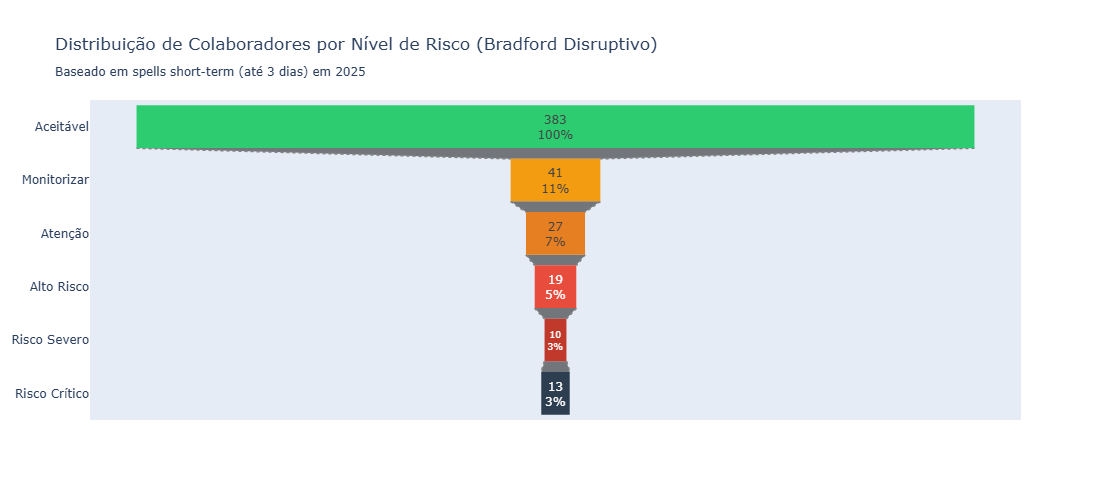

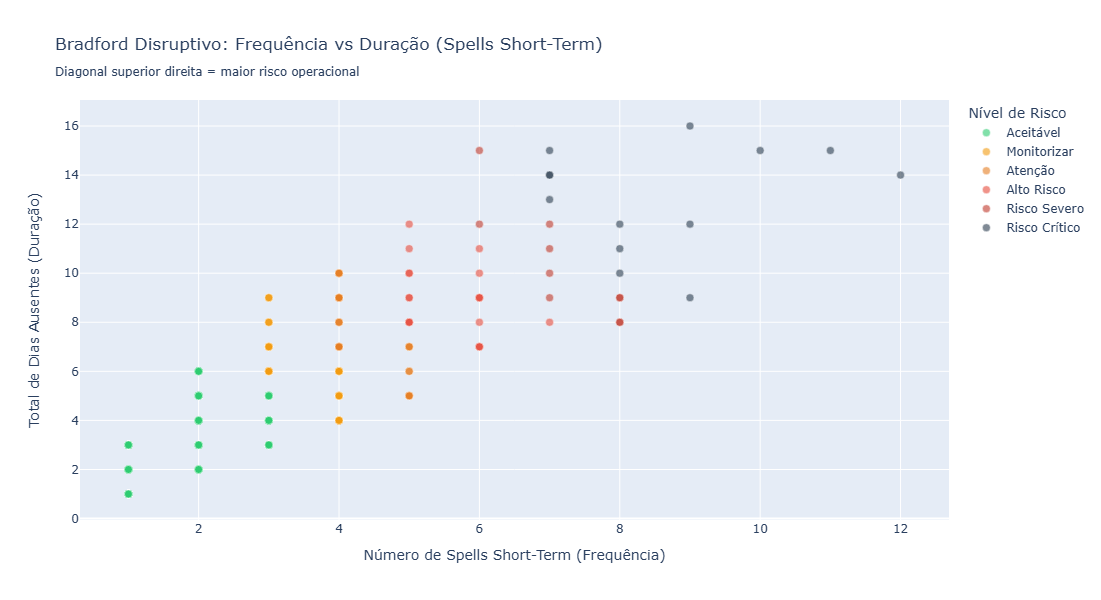


Criando heatmap Bradford por Operação x Categoria (segmentos >= 20 colaboradores)...


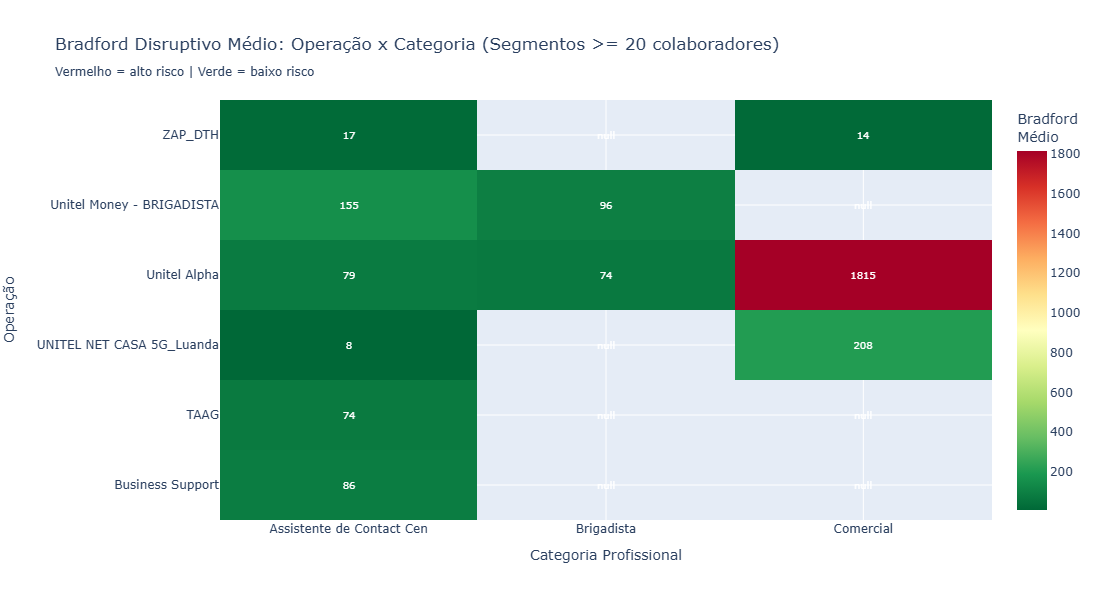

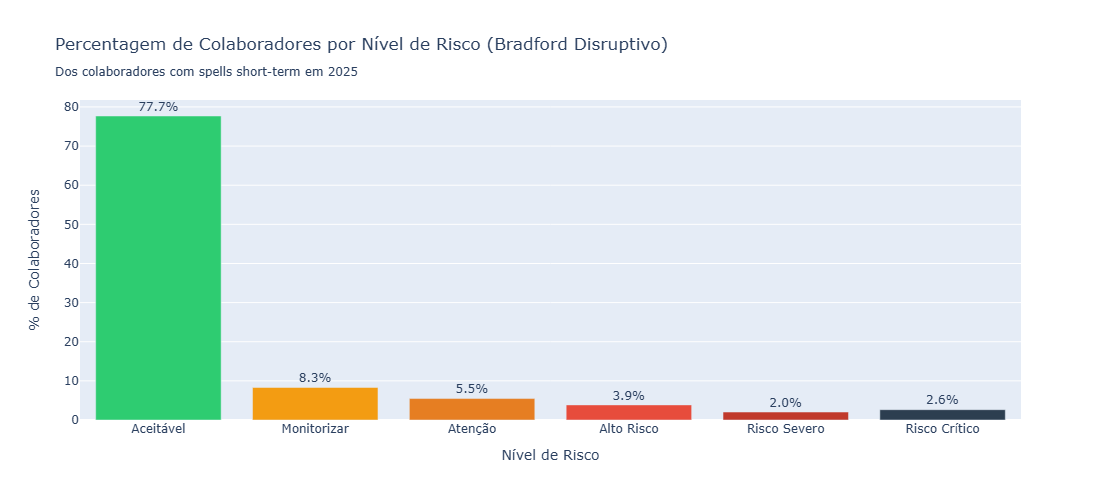


Visualizações do Bradford Disruptivo criadas
GRUPO 5 CONCLUÍDO


In [100]:
# VIZ 1: Distribuição por Risk Level (Funil)
fig1 = go.Figure()

dist_risk_sorted = dist_risk.sort_index()
labels = [x.split('. ')[1] for x in dist_risk_sorted.index]
values = dist_risk_sorted.values

colors = ['#2ecc71', '#f39c12', '#e67e22', '#e74c3c', '#c0392b', '#2c3e50']

fig1.add_trace(go.Funnel(
    y=labels,
    x=values,
    textposition='inside',
    textinfo='value+percent initial',
    marker=dict(color=colors),
    connector={"line": {"color": "gray", "dash": "dot", "width": 2}}
))

fig1.update_layout(
    title='Distribuição de Colaboradores por Nível de Risco (Bradford Disruptivo)<br><sub>Baseado em spells short-term (até 3 dias) em 2025</sub>',
    height=500
)

fig1.show()

# VIZ 2: Scatter Plot - Frequency vs Duration (short-term)
fig2 = go.Figure()

color_map = {
    '1. Aceitável': '#2ecc71',
    '2. Monitorizar': '#f39c12',
    '3. Atenção': '#e67e22',
    '4. Alto Risco': '#e74c3c',
    '5. Risco Severo': '#c0392b',
    '6. Risco Crítico': '#2c3e50'
}

for risk_level in sorted(df_bradford_disruptivo['risk_level'].unique()):
    df_temp = df_bradford_disruptivo[df_bradford_disruptivo['risk_level'] == risk_level]
    
    fig2.add_trace(go.Scatter(
        x=df_temp['num_spells_short'],
        y=df_temp['total_dias_short'],
        mode='markers',
        name=risk_level.split('. ')[1],
        marker=dict(
            size=8,
            color=color_map.get(risk_level, 'gray'),
            opacity=0.6,
            line=dict(width=0.5, color='white')
        ),
        hovertemplate='<b>%{text}</b><br>Spells Short-Term: %{x}<br>Dias: %{y}<br>Bradford: %{customdata:.0f}<extra></extra>',
        text=df_temp['nome_colaborador'],
        customdata=df_temp['bradford_disruptivo']
    ))

fig2.update_layout(
    title='Bradford Disruptivo: Frequência vs Duração (Spells Short-Term)<br><sub>Diagonal superior direita = maior risco operacional</sub>',
    xaxis_title='Número de Spells Short-Term (Frequência)',
    yaxis_title='Total de Dias Ausentes (Duração)',
    height=600,
    showlegend=True,
    legend=dict(title='Nível de Risco')
)

fig2.show()

# VIZ 3: Heatmap - Bradford médio por Operação x Categoria (filtrado >= 20)
if 'operacao' in df_bradford_segmentos.columns:
    print('\nCriando heatmap Bradford por Operação x Categoria (segmentos >= 20 colaboradores)...')
    
    # Filtrar operações e categorias com >= 20 colaboradores
    ops_validas = bradford_por_op_filtrado.head(10).index
    cats_validas = bradford_por_cat_filtrado.head(10).index
    
    df_heatmap = df_bradford_segmentos[
        (df_bradford_segmentos['operacao'].isin(ops_validas)) &
        (df_bradford_segmentos['categoria_profissional'].isin(cats_validas))
    ]
    
    if len(df_heatmap) > 0:
        pivot_bradford = df_heatmap.pivot_table(
            index='operacao',
            columns='categoria_profissional',
            values='bradford_disruptivo',
            aggfunc='mean'
        )
        
        fig3 = go.Figure(data=go.Heatmap(
            z=pivot_bradford.values,
            x=[str(c)[:25] for c in pivot_bradford.columns],
            y=[str(o)[:25] for o in pivot_bradford.index],
            colorscale='RdYlGn_r',
            text=pivot_bradford.values.round(0),
            texttemplate='%{text}',
            textfont={"size": 10},
            colorbar=dict(title="Bradford<br>Médio"),
            hovertemplate='Operação: %{y}<br>Categoria: %{x}<br>Bradford: %{z:.0f}<extra></extra>'
        ))
        
        fig3.update_layout(
            title='Bradford Disruptivo Médio: Operação x Categoria (Segmentos >= 20 colaboradores)<br><sub>Vermelho = alto risco | Verde = baixo risco</sub>',
            xaxis_title='Categoria Profissional',
            yaxis_title='Operação',
            height=600,
            width=1000
        )
        
        fig3.show()

# VIZ 4: Comparação: % de colaboradores por risk level
pct_por_risk = (dist_risk / len(df_bradford_disruptivo) * 100).sort_index()

fig4 = go.Figure()

fig4.add_trace(go.Bar(
    x=labels,
    y=pct_por_risk.values,
    marker_color=colors,
    text=[f'{v:.1f}%' for v in pct_por_risk.values],
    textposition='outside'
))

fig4.update_layout(
    title='Percentagem de Colaboradores por Nível de Risco (Bradford Disruptivo)<br><sub>Dos colaboradores com spells short-term em 2025</sub>',
    xaxis_title='Nível de Risco',
    yaxis_title='% de Colaboradores',
    height=500
)

fig4.show()

print('\nVisualizações do Bradford Disruptivo criadas')
print('='*70)
print('GRUPO 5 CONCLUÍDO')
print('='*70)

## 6. DETEÇÃO DE PADRÕES SUSPEITOS

### 6.1 Padrão Segunda/Sexta (Weekend Pattern)


Padrão Segunda/Sexta (Spells Short-Term):
   Spells que começam à segunda: 196 (17.3%)
   Baseline esperado: 20.0%
   Desvio: -2.7 pontos percentuais

   Spells que terminam à sexta: 187 (16.5%)
   Baseline esperado: 20.0%
   Desvio: -3.5 pontos percentuais

Colaboradores com padrão suspeito Segunda/Sexta:
   0 colaboradores (0.0%)
   Critério: >50% dos spells começam 2ª OU terminam 6ª (mínimo 5 spells)


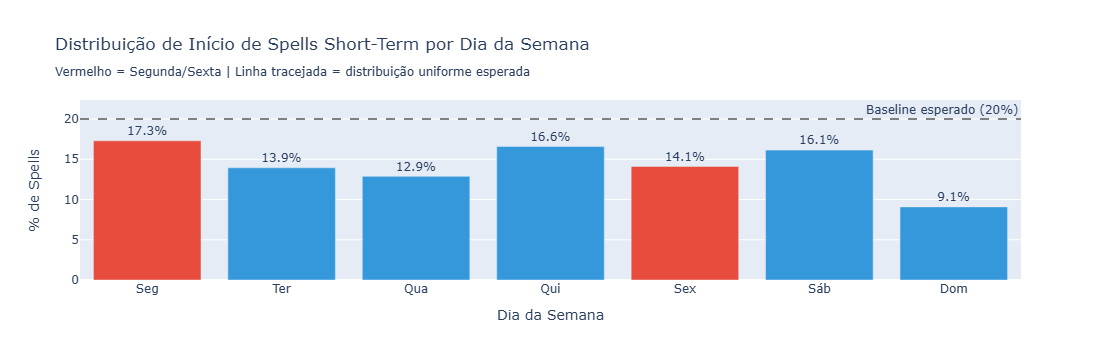

In [107]:
# Proporção de spells que começam à segunda
spells_inicio_segunda = df_spells_disruptivos[df_spells_disruptivos['dia_semana_inicio'] == 'Monday'].shape[0]
prop_inicio_segunda = spells_inicio_segunda / len(df_spells_disruptivos) * 100

# Proporção de spells que terminam à sexta
spells_fim_sexta = df_spells_disruptivos[df_spells_disruptivos['dia_semana_fim'] == 'Friday'].shape[0]
prop_fim_sexta = spells_fim_sexta / len(df_spells_disruptivos) * 100

# Baseline esperado (segunda = 20% dos dias úteis, sexta = 20%)
baseline_esperado = 20.0

print(f'\nPadrão Segunda/Sexta (Spells Short-Term):')
print(f'   Spells que começam à segunda: {spells_inicio_segunda:,} ({prop_inicio_segunda:.1f}%)')
print(f'   Baseline esperado: {baseline_esperado:.1f}%')
print(f'   Desvio: {prop_inicio_segunda - baseline_esperado:+.1f} pontos percentuais')

print(f'\n   Spells que terminam à sexta: {spells_fim_sexta:,} ({prop_fim_sexta:.1f}%)')
print(f'   Baseline esperado: {baseline_esperado:.1f}%')
print(f'   Desvio: {prop_fim_sexta - baseline_esperado:+.1f} pontos percentuais')

# Análise por colaborador
df_padroes_seg_sex = df_spells_disruptivos.groupby('login_colaborador').agg({
    'spell_id': 'count',
    'dia_semana_inicio': lambda x: (x == 'Monday').sum(),
    'dia_semana_fim': lambda x: (x == 'Friday').sum()
}).reset_index()

df_padroes_seg_sex.columns = ['login_colaborador', 'total_spells', 'inicio_segunda', 'fim_sexta']

# Calcular proporções
df_padroes_seg_sex['prop_inicio_segunda'] = df_padroes_seg_sex['inicio_segunda'] / df_padroes_seg_sex['total_spells']
df_padroes_seg_sex['prop_fim_sexta'] = df_padroes_seg_sex['fim_sexta'] / df_padroes_seg_sex['total_spells']

# Flag: > 50% dos spells começam à segunda OU terminam à sexta
# Mínimo 5 spells para ser estatisticamente significativo
df_padroes_seg_sex['flag_weekend_pattern'] = (
    ((df_padroes_seg_sex['prop_inicio_segunda'] > 0.5) | 
     (df_padroes_seg_sex['prop_fim_sexta'] > 0.5)) &
    (df_padroes_seg_sex['total_spells'] >= 5)
)

n_flagged_weekend = df_padroes_seg_sex['flag_weekend_pattern'].sum()
pct_flagged_weekend = (n_flagged_weekend / len(df_padroes_seg_sex)) * 100

print(f'\nColaboradores com padrão suspeito Segunda/Sexta:')
print(f'   {n_flagged_weekend} colaboradores ({pct_flagged_weekend:.1f}%)')
print(f'   Critério: >50% dos spells começam 2ª OU terminam 6ª (mínimo 5 spells)')

# Visualização: Distribuição de início de spells por dia da semana
ordem_dias = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dias_pt = ['Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'Sáb', 'Dom']

inicio_por_dia = df_spells_disruptivos['dia_semana_inicio'].value_counts().reindex(ordem_dias, fill_value=0)
prop_por_dia = (inicio_por_dia / len(df_spells_disruptivos) * 100)

fig_seg_sex = go.Figure()

colors = ['#e74c3c' if dia in ['Monday', 'Friday'] else '#3498db' for dia in ordem_dias]

fig_seg_sex.add_trace(go.Bar(
    x=dias_pt,
    y=prop_por_dia.values,
    marker_color=colors,
    text=[f'{v:.1f}%' for v in prop_por_dia.values],
    textposition='outside'
))

# Linha de baseline (20%)
fig_seg_sex.add_hline(
    y=20,
    line_dash="dash",
    line_color="gray",
    annotation_text="Baseline esperado (20%)"
)

fig_seg_sex.update_layout(
    title='Distribuição de Início de Spells Short-Term por Dia da Semana<br><sub>Vermelho = Segunda/Sexta | Linha tracejada = distribuição uniforme esperada</sub>',
    xaxis_title='Dia da Semana',
    yaxis_title='% de Spells',
    height=500
)

fig_seg_sex.show()

### 6.2 Padrão de Ponte - Adjacentes a Feriados

In [109]:
# Feriados nacionais de Angola (2024-2025)
feriados_angola = pd.to_datetime([
    # 2024
    '2024-01-01',  # Ano Novo
    '2024-02-04',  # Início da Luta Armada
    '2024-02-13',  # Carnaval
    '2024-03-08',  # Dia Internacional da Mulher
    '2024-03-29',  # Sexta-feira Santa
    '2024-03-31',  # Páscoa
    '2024-04-04',  # Dia da Paz
    '2024-05-01',  # Dia do Trabalhador
    '2024-09-17',  # Dia dos Heróis Nacionais
    '2024-11-02',  # Dia dos Finados
    '2024-11-11',  # Dia da Independência
    '2024-12-25',  # Natal
    # 2025
    '2025-01-01',  # Ano Novo
    '2025-02-04',  # Início da Luta Armada
    '2025-03-03',  # Carnaval (exemplo, ajustar)
    '2025-03-08',  # Dia Internacional da Mulher
    '2025-04-04',  # Dia da Paz
    '2025-04-18',  # Sexta-feira Santa (exemplo, ajustar)
    '2025-05-01',  # Dia do Trabalhador
    '2025-09-17',  # Dia dos Heróis Nacionais
    '2025-11-02',  # Dia dos Finados
    '2025-11-11',  # Dia da Independência
    '2025-12-25',  # Natal
])

print(f'Feriados considerados: {len(feriados_angola)}')

# Função para verificar adjacência
def is_adjacent_to_holiday(date, holidays, tolerance=1):
    """Verifica se data está a ±tolerance dias de um feriado"""
    for holiday in holidays:
        diff = abs((date - holiday).days)
        if diff <= tolerance:
            return True
    return False

# Identificar spells adjacentes
df_spells_disruptivos['inicio_adj_feriado'] = df_spells_disruptivos['data_inicio'].apply(
    lambda x: is_adjacent_to_holiday(x, feriados_angola)
)

df_spells_disruptivos['fim_adj_feriado'] = df_spells_disruptivos['data_fim'].apply(
    lambda x: is_adjacent_to_holiday(x, feriados_angola)
)

n_inicio_adj = df_spells_disruptivos['inicio_adj_feriado'].sum()
n_fim_adj = df_spells_disruptivos['fim_adj_feriado'].sum()
prop_inicio_adj = (n_inicio_adj / len(df_spells_disruptivos)) * 100
prop_fim_adj = (n_fim_adj / len(df_spells_disruptivos)) * 100

print(f'\nPadrão de Ponte (Spells Short-Term):')
print(f'   Spells que começam adjacentes a feriado: {n_inicio_adj:,} ({prop_inicio_adj:.1f}%)')
print(f'   Spells que terminam adjacentes a feriado: {n_fim_adj:,} ({prop_fim_adj:.1f}%)')

# Por colaborador
df_ponte_colab = df_spells_disruptivos.groupby('login_colaborador').agg({
    'spell_id': 'count',
    'inicio_adj_feriado': 'sum',
    'fim_adj_feriado': 'sum'
}).reset_index()

df_ponte_colab.columns = ['login_colaborador', 'total_spells', 'inicio_adj', 'fim_adj']
df_ponte_colab['num_adj_total'] = df_ponte_colab['inicio_adj'] + df_ponte_colab['fim_adj']
df_ponte_colab['prop_ponte'] = df_ponte_colab['num_adj_total'] / (df_ponte_colab['total_spells'] * 2)

# Flag: > 40% adjacentes a feriados (mínimo 5 spells)
df_ponte_colab['flag_bridge_pattern'] = (
    (df_ponte_colab['prop_ponte'] > 0.4) &
    (df_ponte_colab['total_spells'] >= 5)
)

n_flagged_ponte = df_ponte_colab['flag_bridge_pattern'].sum()
pct_flagged_ponte = (n_flagged_ponte / len(df_ponte_colab)) * 100

print(f'\nColaboradores com padrão de ponte suspeito:')
print(f'   {n_flagged_ponte} colaboradores ({pct_flagged_ponte:.1f}%)')
print(f'   Critério: >40% adjacentes a feriados (mínimo 5 spells)')

Feriados considerados: 23

Padrão de Ponte (Spells Short-Term):
   Spells que começam adjacentes a feriado: 167 (14.7%)
   Spells que terminam adjacentes a feriado: 165 (14.6%)

Colaboradores com padrão de ponte suspeito:
   0 colaboradores (0.0%)
   Critério: >40% adjacentes a feriados (mínimo 5 spells)


### 6.3 Análise de Baixas Médicas Short-Term (Possível Abuso)


Baixas Médicas Short-Term (<=3 dias):
   Total: 468 (41.3% dos spells short-term)

Distribuição de baixas médicas short-term por dia de início:
   Seg:   89 ( 19.0%)
   Ter:   65 ( 13.9%)
   Qua:   69 ( 14.7%)
   Qui:   65 ( 13.9%)
   Sex:   73 ( 15.6%)
   Sáb:   46 (  9.8%)
   Dom:   61 ( 13.0%)

Colaboradores com padrão suspeito de baixas médicas:
   1 colaboradores (0.4%)
   Critério: >=3 baixas médicas short-term, >60% começam à segunda


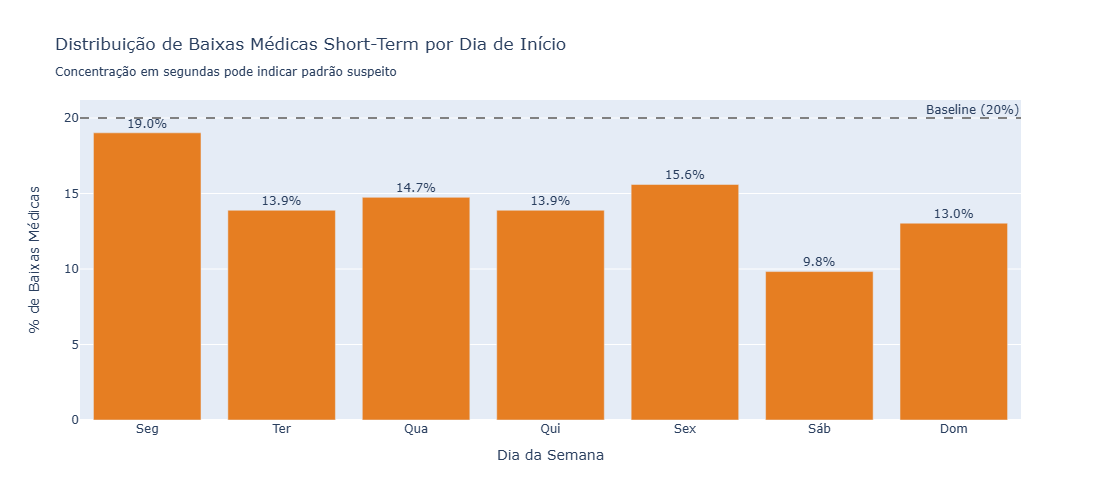

In [111]:
# Filtrar spells short-term que são ausências médicas
df_medicas_short = df_spells_disruptivos[
    df_spells_disruptivos['nivel2_predominante'] == 'Ausência Médica'
].copy()

n_medicas_short = len(df_medicas_short)
prop_medicas = (n_medicas_short / len(df_spells_disruptivos)) * 100

print(f'\nBaixas Médicas Short-Term (<=3 dias):')
print(f'   Total: {n_medicas_short:,} ({prop_medicas:.1f}% dos spells short-term)')

if n_medicas_short > 0:
    # Distribuição por dia da semana
    medicas_por_dia = df_medicas_short['dia_semana_inicio'].value_counts().reindex(ordem_dias, fill_value=0)
    prop_medicas_dia = (medicas_por_dia / n_medicas_short * 100)
    
    print(f'\nDistribuição de baixas médicas short-term por dia de início:')
    for i, dia in enumerate(ordem_dias):
        print(f'   {dias_pt[i]:3s}: {medicas_por_dia[dia]:4.0f} ({prop_medicas_dia[dia]:5.1f}%)')
    
    # Por colaborador
    df_medicas_colab = df_medicas_short.groupby('login_colaborador').agg({
        'spell_id': 'count',
        'dia_semana_inicio': lambda x: (x == 'Monday').sum()
    }).reset_index()
    
    df_medicas_colab.columns = ['login_colaborador', 'num_medicas_short', 'inicio_segunda']
    df_medicas_colab['prop_segunda'] = df_medicas_colab['inicio_segunda'] / df_medicas_colab['num_medicas_short']
    
    # Flag: >= 3 baixas médicas short-term, >60% começam à segunda
    df_medicas_colab['flag_medica_suspeita'] = (
        (df_medicas_colab['num_medicas_short'] >= 3) &
        (df_medicas_colab['prop_segunda'] > 0.6)
    )
    
    n_flagged_medicas = df_medicas_colab['flag_medica_suspeita'].sum()
    pct_flagged_medicas = (n_flagged_medicas / len(df_medicas_colab)) * 100
    
    print(f'\nColaboradores com padrão suspeito de baixas médicas:')
    print(f'   {n_flagged_medicas} colaboradores ({pct_flagged_medicas:.1f}%)')
    print(f'   Critério: >=3 baixas médicas short-term, >60% começam à segunda')
    
    # Visualização
    fig_medicas = go.Figure()
    
    fig_medicas.add_trace(go.Bar(
        x=dias_pt,
        y=prop_medicas_dia.values,
        marker_color='#e67e22',
        text=[f'{v:.1f}%' for v in prop_medicas_dia.values],
        textposition='outside'
    ))
    
    fig_medicas.add_hline(
        y=20,
        line_dash="dash",
        line_color="gray",
        annotation_text="Baseline (20%)"
    )
    
    fig_medicas.update_layout(
        title='Distribuição de Baixas Médicas Short-Term por Dia de Início<br><sub>Concentração em segundas pode indicar padrão suspeito</sub>',
        xaxis_title='Dia da Semana',
        yaxis_title='% de Baixas Médicas',
        height=500
    )
    
    fig_medicas.show()

### 6.4 Síntese de Padrões Suspeitos


Distribuição de Flags de Padrões Suspeitos:
   1 flag         :    1 (  0.2%)
   Sem flags      :  492 ( 99.8%)

Colaboradores com 2+ flags (alta suspeita):
   0 colaboradores (0.0%)


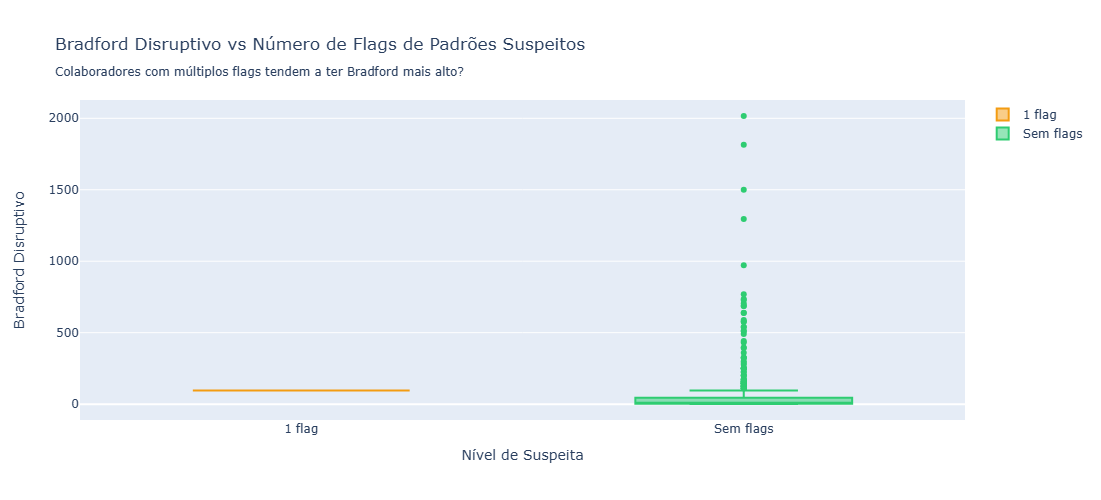


=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
GRUPO 6 CONCLUÍDO


In [113]:
# Combinar todos os flags
df_sintese = df_bradford_disruptivo[['login_colaborador', 'nome_colaborador', 'bradford_disruptivo', 'risk_level']].copy()

# Merge com flags
df_sintese = df_sintese.merge(
    df_padroes_seg_sex[['login_colaborador', 'flag_weekend_pattern']],
    on='login_colaborador',
    how='left'
).fillna(False)

df_sintese = df_sintese.merge(
    df_ponte_colab[['login_colaborador', 'flag_bridge_pattern']],
    on='login_colaborador',
    how='left'
).fillna(False)

if n_medicas_short > 0:
    df_sintese = df_sintese.merge(
        df_medicas_colab[['login_colaborador', 'flag_medica_suspeita']],
        on='login_colaborador',
        how='left'
    ).fillna(False)
else:
    df_sintese['flag_medica_suspeita'] = False

# Contar número total de flags
df_sintese['num_flags'] = (
    df_sintese['flag_weekend_pattern'].astype(int) +
    df_sintese['flag_bridge_pattern'].astype(int) +
    df_sintese['flag_medica_suspeita'].astype(int)
)

# Classificar por nível de suspeita
def classificar_suspeita(row):
    if row['num_flags'] == 0:
        return 'Sem flags'
    elif row['num_flags'] == 1:
        return '1 flag'
    elif row['num_flags'] == 2:
        return '2 flags'
    else:
        return '3 flags'

df_sintese['nivel_suspeita'] = df_sintese.apply(classificar_suspeita, axis=1)

# Estatísticas
print(f'\nDistribuição de Flags de Padrões Suspeitos:')
dist_flags = df_sintese['nivel_suspeita'].value_counts().sort_index()
for nivel, count in dist_flags.items():
    pct = (count / len(df_sintese)) * 100
    print(f'   {nivel:15s}: {count:4,} ({pct:5.1f}%)')

# Colaboradores com múltiplos flags
colab_multiplos_flags = df_sintese[df_sintese['num_flags'] >= 2]
n_multiplos = len(colab_multiplos_flags)

print(f'\nColaboradores com 2+ flags (alta suspeita):')
print(f'   {n_multiplos} colaboradores ({n_multiplos/len(df_sintese)*100:.1f}%)')

# Visualização: Relação entre Bradford e Flags
fig_sintese = go.Figure()

colors_sintese = {
    'Sem flags': '#2ecc71',
    '1 flag': '#f39c12',
    '2 flags': '#e74c3c',
    '3 flags': '#c0392b'
}

for nivel in sorted(df_sintese['nivel_suspeita'].unique()):
    df_temp = df_sintese[df_sintese['nivel_suspeita'] == nivel]
    
    fig_sintese.add_trace(go.Box(
        y=df_temp['bradford_disruptivo'],
        name=nivel,
        marker_color=colors_sintese.get(nivel, 'gray')
    ))

fig_sintese.update_layout(
    title='Bradford Disruptivo vs Número de Flags de Padrões Suspeitos<br><sub>Colaboradores com múltiplos flags tendem a ter Bradford mais alto?</sub>',
    xaxis_title='Nível de Suspeita',
    yaxis_title='Bradford Disruptivo',
    height=500
)

fig_sintese.show()

print('\n='*70)
print('GRUPO 6 CONCLUÍDO')
print('='*70)

---

## 7. ANÁLISE DE COHORTS (por Data de Ingresso)

**Objetivo**: Investigar se colaboradores mais novos têm taxas de absentismo diferentes.

**Hipóteses a testar**:
- Novos colaboradores podem ter mais ausências (adaptação, problemas iniciais)
- Ou menos ausências (honeymoon period, medo de consequências)

### 7.1 Preparar dados

In [122]:
df_base_absentismo.columns

Index(['login_colaborador', 'Data', 'nome_colaborador',
       'categoria_profissional', 'segmento', 'operacao', 'departamento',
       'segmento_processado_codigo', 'codigo_nivel_2', 'Contagem_ID',
       'DtActivacao', 'DtDesactivacao', 'Activo?', 'Codigo Segmento',
       'Nivel 1', 'Nivel 2', 'Dia_Semana', 'Ano_Mes'],
      dtype='object')

Campo DtActivacao encontrado
Colaboradores com DtActivacao válida: 1,184

Absentismo por Cohort de Senioridade (2025):

Cohort    | N Colab | Base Total | Faltas | Taxa % | Faltas/Colab
---------------------------------------------------------------------------
<1 ano    |    1184 |     47,397 |  2,422 |   5.11 |          2.0
1-2 anos  |    1184 |     11,851 |    404 |   3.41 |          0.3
2-3 anos  |    1184 |      6,881 |    212 |   3.08 |          0.2
3-5 anos  |    1184 |     13,542 |    217 |   1.60 |          0.2
>5 anos   |    1184 |     37,689 |    870 |   2.31 |          0.7


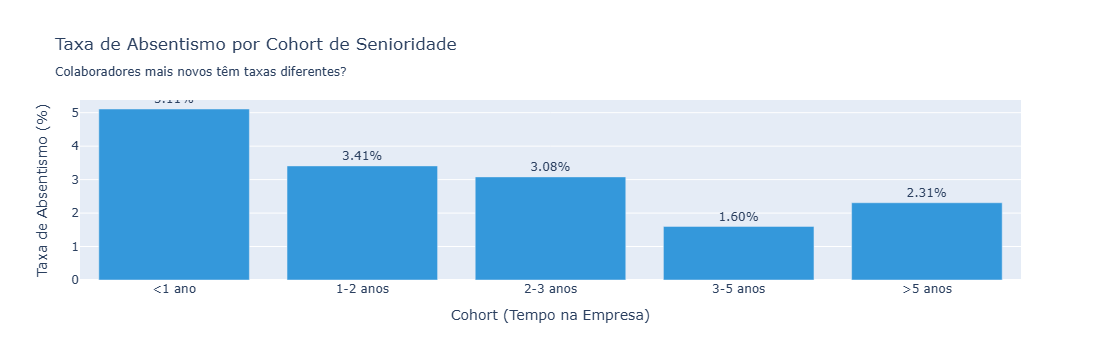

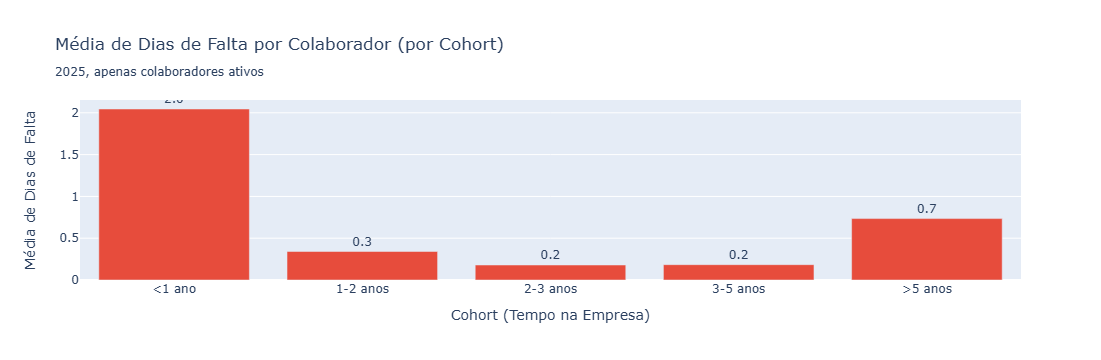


Insights:
   Cohort com menor absentismo: 3-5 anos (1.60%)
   Cohort com maior absentismo: <1 ano (5.11%)

GRUPO 7 CONCLUÍDO


In [124]:
if 'DtActivacao' not in df_base_absentismo.columns:
    print('Campo "DtActivacao" não encontrado!')
    print('Análise de cohorts requer data de ativação.')
    print('Pulando este grupo.')
else:
    print('Campo DtActivacao encontrado')
    
    # Preparar dados (usar apenas 2025, ativos)
    df_cohort = df_base_absentismo[
        (df_base_absentismo['Activo?'] == 'Sim') &
        (df_base_absentismo['Data'].dt.year == 2025)
    ][['login_colaborador', 'nome_colaborador', 'DtActivacao', 'Data', 'Nivel 1', 'categoria_profissional']].copy()
    
    df_cohort['DtActivacao'] = pd.to_datetime(df_cohort['DtActivacao'], errors='coerce')
    df_cohort = df_cohort.dropna(subset=['DtActivacao'])
    
    print(f'Colaboradores com DtActivacao válida: {df_cohort["login_colaborador"].nunique():,}')
    
    # Calcular senioridade (em relação a 2025-06-30)
    data_ref = pd.Timestamp('2025-06-30')
    df_cohort['senioridade_anos'] = (data_ref - df_cohort['DtActivacao']).dt.days / 365.25
    
    # Criar cohorts
    df_cohort['cohort'] = pd.cut(
        df_cohort['senioridade_anos'],
        bins=[0, 1, 2, 3, 5, 100],
        labels=['<1 ano', '1-2 anos', '2-3 anos', '3-5 anos', '>5 anos']
    )
    
    # Separar base e faltas
    df_cohort_base = df_cohort[df_cohort['Nivel 1'].isin(['Trabalho Pago', 'Falta Justificada', 'Falta Injustificada'])].copy()
    df_cohort_faltas = df_cohort[df_cohort['Nivel 1'].isin(['Falta Justificada', 'Falta Injustificada'])].copy()
    
    # Estatísticas por cohort
    cohort_stats = pd.DataFrame()
    
    # Base por cohort
    base_cohort = df_cohort_base.groupby(['cohort', 'login_colaborador']).size().groupby('cohort').agg(['size', 'sum'])
    base_cohort.columns = ['num_colaboradores', 'total_base']
    
    # Faltas por cohort
    faltas_cohort = df_cohort_faltas.groupby('cohort').agg({
        'Data': 'count'
    }).rename(columns={'Data': 'total_faltas'})
    
    # Combinar
    cohort_stats = base_cohort.join(faltas_cohort, how='left').fillna(0)
    cohort_stats['taxa_absentismo'] = (cohort_stats['total_faltas'] / cohort_stats['total_base'] * 100)
    cohort_stats['media_faltas_colab'] = cohort_stats['total_faltas'] / cohort_stats['num_colaboradores']
    
    print('\nAbsentismo por Cohort de Senioridade (2025):')
    print('\nCohort    | N Colab | Base Total | Faltas | Taxa % | Faltas/Colab')
    print('-' * 75)
    for cohort, row in cohort_stats.iterrows():
        print(f'{str(cohort):9s} | {row["num_colaboradores"]:7.0f} | {row["total_base"]:10,.0f} | {row["total_faltas"]:6,.0f} | {row["taxa_absentismo"]:6.2f} | {row["media_faltas_colab"]:12.1f}')
    
    # Visualização 1: Taxa de absentismo por cohort
    fig_cohort1 = go.Figure()
    
    fig_cohort1.add_trace(go.Bar(
        x=cohort_stats.index.astype(str),
        y=cohort_stats['taxa_absentismo'],
        marker_color='#3498db',
        text=[f'{v:.2f}%' for v in cohort_stats['taxa_absentismo']],
        textposition='outside'
    ))
    
    fig_cohort1.update_layout(
        title='Taxa de Absentismo por Cohort de Senioridade<br><sub>Colaboradores mais novos têm taxas diferentes?</sub>',
        xaxis_title='Cohort (Tempo na Empresa)',
        yaxis_title='Taxa de Absentismo (%)',
        height=500
    )
    
    fig_cohort1.show()
    
    # Visualização 2: Média de faltas por colaborador
    fig_cohort2 = go.Figure()
    
    fig_cohort2.add_trace(go.Bar(
        x=cohort_stats.index.astype(str),
        y=cohort_stats['media_faltas_colab'],
        marker_color='#e74c3c',
        text=[f'{v:.1f}' for v in cohort_stats['media_faltas_colab']],
        textposition='outside'
    ))
    
    fig_cohort2.update_layout(
        title='Média de Dias de Falta por Colaborador (por Cohort)<br><sub>2025, apenas colaboradores ativos</sub>',
        xaxis_title='Cohort (Tempo na Empresa)',
        yaxis_title='Média de Dias de Falta',
        height=500
    )
    
    fig_cohort2.show()
    
    # Insights
    if len(cohort_stats) > 1:
        cohort_mais_baixo = cohort_stats['taxa_absentismo'].idxmin()
        cohort_mais_alto = cohort_stats['taxa_absentismo'].idxmax()
        
        print(f'\nInsights:')
        print(f'   Cohort com menor absentismo: {cohort_mais_baixo} ({cohort_stats.loc[cohort_mais_baixo, "taxa_absentismo"]:.2f}%)')
        print(f'   Cohort com maior absentismo: {cohort_mais_alto} ({cohort_stats.loc[cohort_mais_alto, "taxa_absentismo"]:.2f}%)')
    
    print('\n' + '='*70)
    print('GRUPO 7 CONCLUÍDO')
    print('='*70)

---

## 8. CLUSTERING DE PERFIS DE ABSENTISMO

**Objetivo**: Segmentar colaboradores em grupos homogéneos por comportamento de absentismo.

**Features para clustering**:
- Número de spells (frequência)
- Total de dias ausentes
- Duração média de spell
- Bradford score
- Proporção de short-term spells

**Algoritmo**: K-Means (3-5 clusters típicos)

### 8.1 Preparar features para clustering

In [130]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Usar df_bradford_disruptivo (2025, ativos, short-term)
features_clustering = [
    'num_spells_short',
    'total_dias_short',
    'bradford_disruptivo'
]

df_cluster = df_bradford_disruptivo[['login_colaborador', 'nome_colaborador', 'categoria_profissional'] + features_clustering].copy()

# Normalizar features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster[features_clustering])

print(f'Features preparadas: {X_scaled.shape}')
print(f'Colaboradores: {len(df_cluster):,}')



Features preparadas: (493, 3)
Colaboradores: 493


### 8.2 Determinar K ideal (Elbow + Silhouette)

K=2: Inertia=632.3, Silhouette=0.705
K=3: Inertia=349.1, Silhouette=0.600
K=4: Inertia=225.5, Silhouette=0.590
K=5: Inertia=147.7, Silhouette=0.546
K=6: Inertia=122.2, Silhouette=0.519
K=7: Inertia=104.5, Silhouette=0.502
K=8: Inertia=91.9, Silhouette=0.496


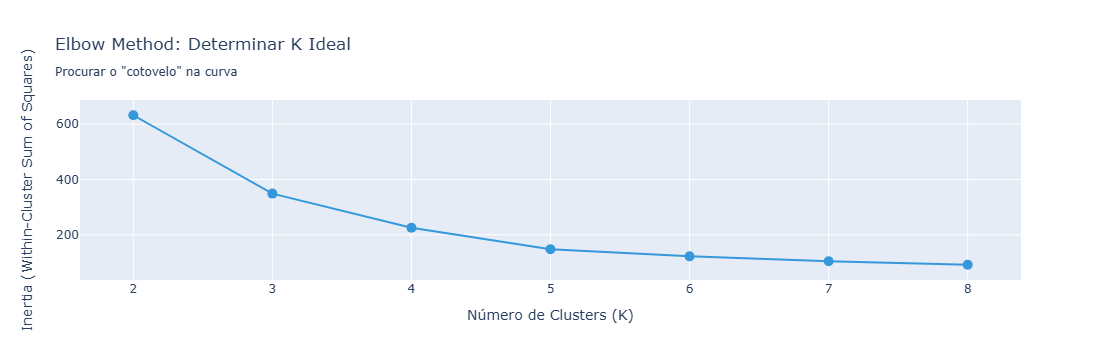

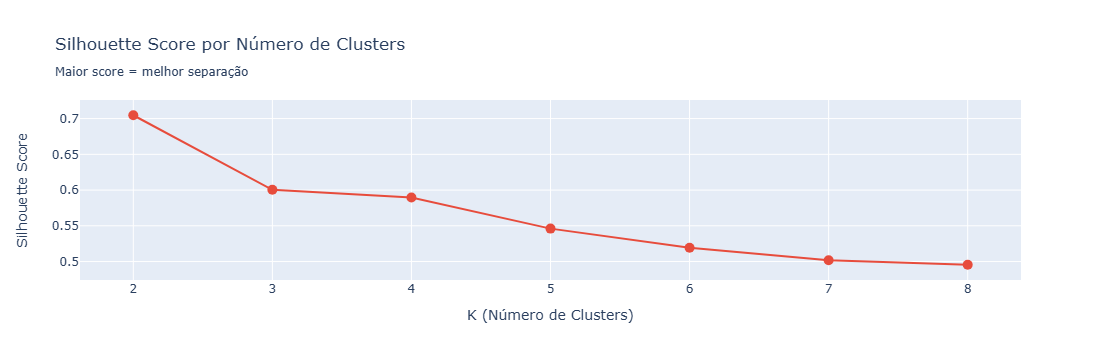


Melhor K por Silhouette: 2 (score=0.705)


In [132]:
K_range = range(2, 9)
inertias = []
silhouette_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, labels))
    print(f'K={k}: Inertia={kmeans.inertia_:.1f}, Silhouette={silhouette_scores[-1]:.3f}')

# Visualização 1: Elbow Method
fig_elbow = go.Figure()

fig_elbow.add_trace(go.Scatter(
    x=list(K_range),
    y=inertias,
    mode='lines+markers',
    marker=dict(size=10, color='#3498db'),
    line=dict(width=2)
))

fig_elbow.update_layout(
    title='Elbow Method: Determinar K Ideal<br><sub>Procurar o "cotovelo" na curva</sub>',
    xaxis_title='Número de Clusters (K)',
    yaxis_title='Inertia (Within-Cluster Sum of Squares)',
    height=450
)

fig_elbow.show()

# Visualização 2: Silhouette Score
fig_silhouette = go.Figure()

fig_silhouette.add_trace(go.Scatter(
    x=list(K_range),
    y=silhouette_scores,
    mode='lines+markers',
    marker=dict(size=10, color='#e74c3c'),
    line=dict(width=2)
))

fig_silhouette.update_layout(
    title='Silhouette Score por Número de Clusters<br><sub>Maior score = melhor separação</sub>',
    xaxis_title='K (Número de Clusters)',
    yaxis_title='Silhouette Score',
    height=450
)

fig_silhouette.show()

# Escolher K (melhor silhouette)
best_k = list(K_range)[silhouette_scores.index(max(silhouette_scores))]
print(f'\nMelhor K por Silhouette: {best_k} (score={max(silhouette_scores):.3f})')

### 8.3 Aplicar clustering com K ideal


Distribuição por cluster:
   Cluster 0: 60 (12.2%)
   Cluster 1: 433 (87.8%)

Perfis dos Clusters:

Cluster | Spells Short | Dias Short | Bradford
-------------------------------------------------------
      0 |          6.1 |        9.9 |    439.9
      1 |          1.8 |        3.0 |     17.5


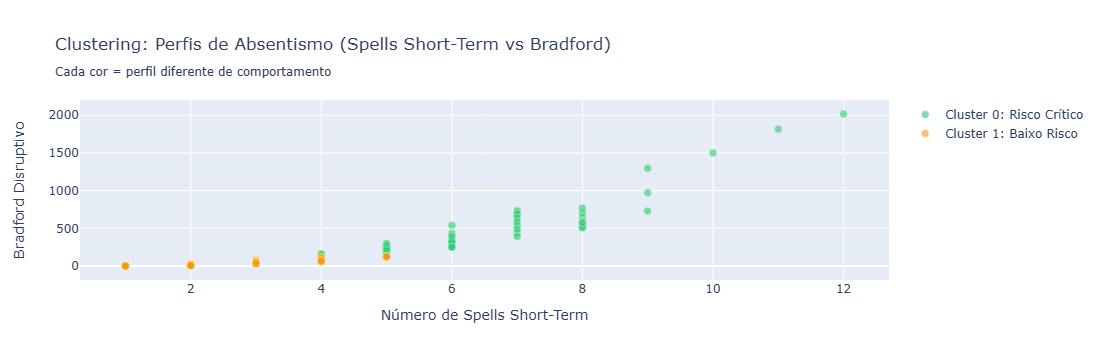


Distribuição de clusters por categoria profissional (top 5 categorias):

Assistente de Contact Center:
   Cluster 1: Baixo Risco: 258
   Cluster 0: Risco Crítico: 30

Brigadista:
   Cluster 1: Baixo Risco: 61
   Cluster 0: Risco Crítico: 13

Comercial:
   Cluster 1: Baixo Risco: 61
   Cluster 0: Risco Crítico: 12

Supervisor Operacional:
   Cluster 1: Baixo Risco: 5
   Cluster 0: Risco Crítico: 2

Técnico de Qualidade:
   Cluster 1: Baixo Risco: 5
   Cluster 0: Risco Crítico: 1

GRUPO 8 CONCLUÍDO


In [134]:
kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
df_cluster['cluster'] = kmeans_final.fit_predict(X_scaled)

print(f'\nDistribuição por cluster:')
dist_clusters = df_cluster['cluster'].value_counts().sort_index()
for cluster, count in dist_clusters.items():
    pct = (count / len(df_cluster)) * 100
    print(f'   Cluster {cluster}: {count:,} ({pct:.1f}%)')

# Perfis dos clusters
print(f'\nPerfis dos Clusters:')
cluster_profiles = df_cluster.groupby('cluster')[features_clustering].mean().round(1)

print('\nCluster | Spells Short | Dias Short | Bradford')
print('-' * 55)
for cluster, row in cluster_profiles.iterrows():
    print(f'{cluster:7d} | {row["num_spells_short"]:12.1f} | {row["total_dias_short"]:10.1f} | {row["bradford_disruptivo"]:8.1f}')

# Nomear clusters (simplificado)
def nomear_cluster(cluster_id, profiles):
    bradford = profiles.loc[cluster_id, 'bradford_disruptivo']
    if bradford < 50:
        return f'Cluster {cluster_id}: Baixo Risco'
    elif bradford < 150:
        return f'Cluster {cluster_id}: Risco Moderado'
    elif bradford < 300:
        return f'Cluster {cluster_id}: Alto Risco'
    else:
        return f'Cluster {cluster_id}: Risco Crítico'

df_cluster['cluster_nome'] = df_cluster['cluster'].apply(lambda x: nomear_cluster(x, cluster_profiles))

# Visualização: Scatter 2D (Spells vs Bradford)
fig_cluster_scatter = go.Figure()

colors_cluster = ['#2ecc71', '#f39c12', '#e67e22', '#e74c3c', '#c0392b', '#9b59b6', '#3498db', '#1abc9c']

for cluster in sorted(df_cluster['cluster'].unique()):
    df_temp = df_cluster[df_cluster['cluster'] == cluster]
    cluster_nome = df_temp['cluster_nome'].iloc[0]
    
    fig_cluster_scatter.add_trace(go.Scatter(
        x=df_temp['num_spells_short'],
        y=df_temp['bradford_disruptivo'],
        mode='markers',
        name=cluster_nome,
        marker=dict(
            size=8,
            color=colors_cluster[cluster % len(colors_cluster)],
            opacity=0.6,
            line=dict(width=0.5, color='white')
        ),
        hovertemplate='<b>%{text}</b><br>Spells: %{x}<br>Bradford: %{y:.0f}<extra></extra>',
        text=df_temp['nome_colaborador']
    ))

fig_cluster_scatter.update_layout(
    title='Clustering: Perfis de Absentismo (Spells Short-Term vs Bradford)<br><sub>Cada cor = perfil diferente de comportamento</sub>',
    xaxis_title='Número de Spells Short-Term',
    yaxis_title='Bradford Disruptivo',
    height=600,
    showlegend=True
)

fig_cluster_scatter.show()

# Distribuição de clusters por categoria profissional
print('\nDistribuição de clusters por categoria profissional (top 5 categorias):')
top5_cats = df_cluster['categoria_profissional'].value_counts().head(5).index

for cat in top5_cats:
    df_cat = df_cluster[df_cluster['categoria_profissional'] == cat]
    print(f'\n{cat}:')
    dist = df_cat['cluster_nome'].value_counts()
    for nome, count in dist.items():
        print(f'   {nome}: {count}')

print('\n' + '='*70)
print('GRUPO 8 CONCLUÍDO')
print('='*70)

## 9. ANÁLISE COMPARATIVA 2024 VS 2025

In [137]:
# Usar dados de 2024 e 2025 (apenas meses equivalentes: Jan-Jun)
df_comparativo = df_base_absentismo[
    ((df_base_absentismo['Data'].dt.year == 2024) & (df_base_absentismo['Data'].dt.month <= 6)) |
    ((df_base_absentismo['Data'].dt.year == 2025) & (df_base_absentismo['Data'].dt.month <= 6))
].copy()

df_comparativo['ano'] = df_comparativo['Data'].dt.year
df_comparativo['mes'] = df_comparativo['Data'].dt.month

# Separar base e faltas
df_comp_base = df_comparativo[df_comparativo['Nivel 1'].isin(['Trabalho Pago', 'Falta Justificada', 'Falta Injustificada'])].copy()
df_comp_faltas = df_comparativo[df_comparativo['Nivel 1'].isin(['Falta Justificada', 'Falta Injustificada'])].copy()

print(f'Período de comparação: Jan-Jun (2024 vs 2025)')
print(f'Registos em análise: {len(df_comparativo):,}')

Período de comparação: Jan-Jun (2024 vs 2025)
Registos em análise: 494,127


### 9.2 Comparação de métricas globais

In [140]:
metricas_ano = []

for ano in [2024, 2025]:
    base_ano = df_comp_base[df_comp_base['ano'] == ano]
    faltas_ano = df_comp_faltas[df_comp_faltas['ano'] == ano]
    
    total_base = len(base_ano)
    total_faltas = len(faltas_ano)
    taxa_abs = (total_faltas / total_base * 100) if total_base > 0 else 0
    
    # Spells do ano
    spells_ano = df_spells[
        (df_spells['data_inicio'].dt.year == ano) &
        (df_spells['data_inicio'].dt.month <= 6)
    ]
    
    num_spells = len(spells_ano)
    duracao_media = spells_ano['duracao_dias'].mean() if len(spells_ano) > 0 else 0
    
    metricas_ano.append({
        'Ano': ano,
        'Base': total_base,
        'Faltas': total_faltas,
        'Taxa Absentismo (%)': taxa_abs,
        'Num Spells': num_spells,
        'Duração Média Spell': duracao_media
    })

df_metricas_comp = pd.DataFrame(metricas_ano)

print('\nComparação de Métricas (Jan-Jun):')
print('\nAno  | Base      | Faltas   | Taxa % | Spells | Dur Média')
print('-' * 65)
for _, row in df_metricas_comp.iterrows():
    print(f'{row["Ano"]} | {row["Base"]:9,.0f} | {row["Faltas"]:8,.0f} | {row["Taxa Absentismo (%)"]:6.2f} | {row["Num Spells"]:6,.0f} | {row["Duração Média Spell"]:9.1f}')

# Variação percentual
if len(df_metricas_comp) == 2:
    var_taxa = df_metricas_comp.iloc[1]['Taxa Absentismo (%)'] - df_metricas_comp.iloc[0]['Taxa Absentismo (%)']
    var_pct_taxa = (var_taxa / df_metricas_comp.iloc[0]['Taxa Absentismo (%)'] * 100)
    
    print(f'\nVariação 2024 -> 2025:')
    print(f'   Taxa de Absentismo: {var_taxa:+.2f} pontos percentuais ({var_pct_taxa:+.1f}%)')
    
    var_spells = df_metricas_comp.iloc[1]['Num Spells'] - df_metricas_comp.iloc[0]['Num Spells']
    var_pct_spells = (var_spells / df_metricas_comp.iloc[0]['Num Spells'] * 100)
    print(f'   Número de Spells: {var_spells:+,.0f} ({var_pct_spells:+.1f}%)')


Comparação de Métricas (Jan-Jun):

Ano  | Base      | Faltas   | Taxa % | Spells | Dur Média
-----------------------------------------------------------------
2024.0 |   239,615 |    8,934 |   3.73 |  2,610 |       3.7
2025.0 |   254,512 |    6,026 |   2.37 |  2,185 |       2.7

Variação 2024 -> 2025:
   Taxa de Absentismo: -1.36 pontos percentuais (-36.5%)
   Número de Spells: -425 (-16.3%)


### 9.3 Comparação mensal (média)

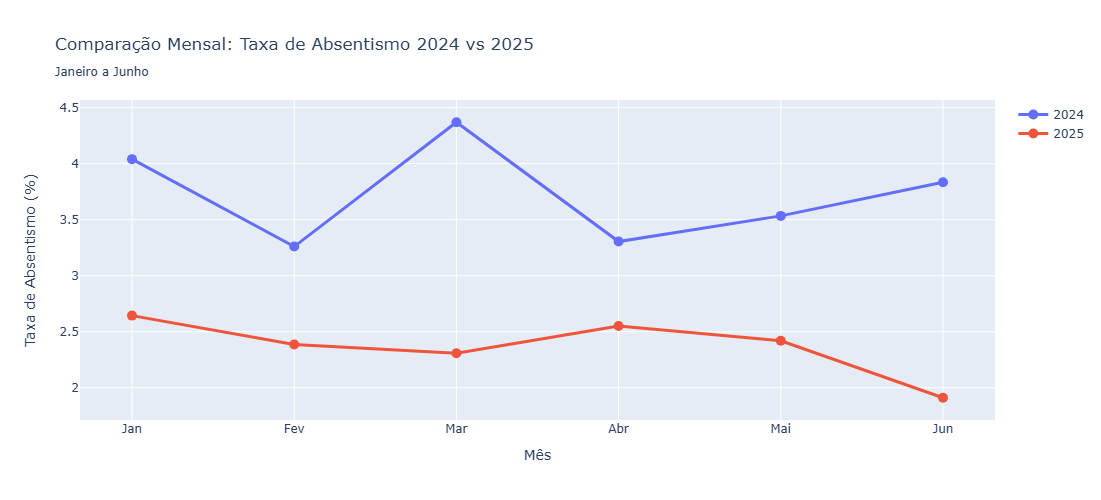

In [143]:
# Taxa por mês
df_comp_mensal = df_comp_base.groupby(['ano', 'mes']).size().reset_index(name='base')
faltas_mensal = df_comp_faltas.groupby(['ano', 'mes']).size().reset_index(name='faltas')

df_comp_mensal = df_comp_mensal.merge(faltas_mensal, on=['ano', 'mes'], how='left').fillna(0)
df_comp_mensal['taxa_abs'] = (df_comp_mensal['faltas'] / df_comp_mensal['base'] * 100)

# Visualização: Comparação mensal
meses_nome = ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun']

fig_comp_mensal = go.Figure()

for ano in [2024, 2025]:
    df_ano = df_comp_mensal[df_comp_mensal['ano'] == ano].sort_values('mes')
    
    fig_comp_mensal.add_trace(go.Scatter(
        x=[meses_nome[m-1] for m in df_ano['mes']],
        y=df_ano['taxa_abs'],
        mode='lines+markers',
        name=str(ano),
        line=dict(width=3),
        marker=dict(size=10)
    ))

fig_comp_mensal.update_layout(
    title='Comparação Mensal: Taxa de Absentismo 2024 vs 2025<br><sub>Janeiro a Junho</sub>',
    xaxis_title='Mês',
    yaxis_title='Taxa de Absentismo (%)',
    height=500,
    hovermode='x unified'
)

fig_comp_mensal.show()

### 9.4 Comparação de distribuição de spells

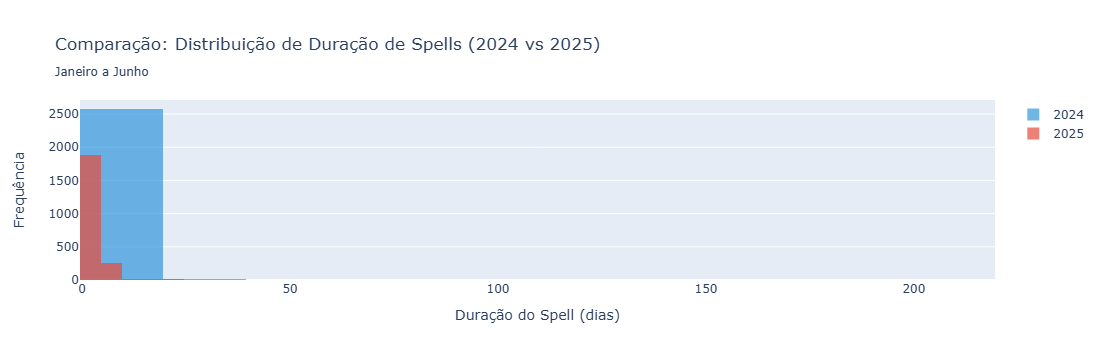


Estatísticas de duração de spells:

2024 (Jan-Jun):
   Média: 3.7 dias
   Mediana: 2.0 dias

2025 (Jan-Jun):
   Média: 2.7 dias
   Mediana: 2.0 dias

GRUPO 9 CONCLUÍDO


In [146]:
# Spells por ano (Jan-Jun)
spells_2024 = df_spells[
    (df_spells['data_inicio'].dt.year == 2024) &
    (df_spells['data_inicio'].dt.month <= 6)
]['duracao_dias']

spells_2025 = df_spells[
    (df_spells['data_inicio'].dt.year == 2025) &
    (df_spells['data_inicio'].dt.month <= 6)
]['duracao_dias']

fig_comp_spells = go.Figure()

fig_comp_spells.add_trace(go.Histogram(
    x=spells_2024,
    name='2024',
    opacity=0.7,
    marker_color='#3498db',
    nbinsx=15
))

fig_comp_spells.add_trace(go.Histogram(
    x=spells_2025,
    name='2025',
    opacity=0.7,
    marker_color='#e74c3c',
    nbinsx=15
))

fig_comp_spells.update_layout(
    title='Comparação: Distribuição de Duração de Spells (2024 vs 2025)<br><sub>Janeiro a Junho</sub>',
    xaxis_title='Duração do Spell (dias)',
    yaxis_title='Frequência',
    barmode='overlay',
    height=500
)

fig_comp_spells.show()

print('\nEstatísticas de duração de spells:')
print(f'\n2024 (Jan-Jun):')
print(f'   Média: {spells_2024.mean():.1f} dias')
print(f'   Mediana: {spells_2024.median():.1f} dias')

print(f'\n2025 (Jan-Jun):')
print(f'   Média: {spells_2025.mean():.1f} dias')
print(f'   Mediana: {spells_2025.median():.1f} dias')

print('\n' + '='*70)
print('GRUPO 9 CONCLUÍDO')
print('='*70)

## 10. CONTROL CHARTS (U-CHART)


U-CHART (2025):
   Semanas analisadas: 27
   Taxa média: 0.126 faltas/colaborador/semana
   Semanas FORA DE CONTROLE: 4 (14.8%)


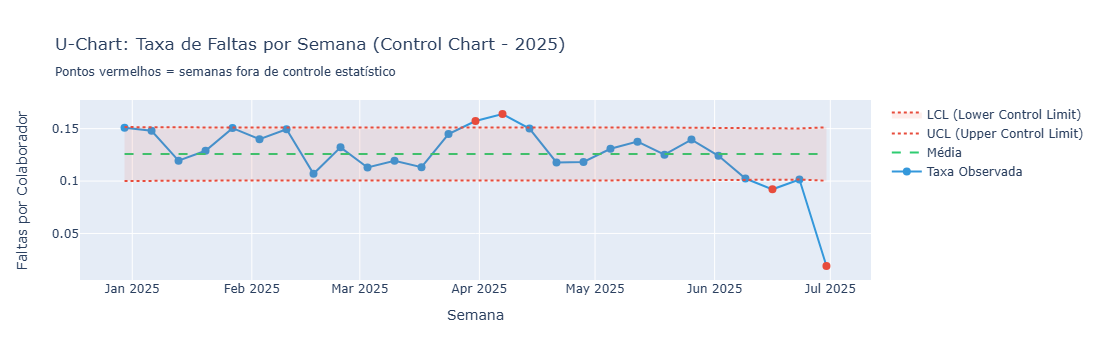


Semanas fora de controle (investigar causas):

Semana     | Ausências | Colab | Taxa   | UCL
-------------------------------------------------------
2025-03-31/2025-04-06 |       277 |  1761 | 0.157 | 0.151
2025-04-07/2025-04-13 |       287 |  1750 | 0.164 | 0.151
2025-06-16/2025-06-22 |       172 |  1867 | 0.092 | 0.150
2025-06-30/2025-07-06 |        33 |  1742 | 0.019 | 0.151

GRUPO 10 CONCLUÍDO


In [149]:
# Usar apenas faltas de 2025
df_uchart = df_faltas[df_faltas['Data'].dt.year == 2025].copy()
df_uchart['semana'] = df_uchart['Data'].dt.to_period('W').astype(str)

# Contar ausências por semana
ausencias_semana = df_uchart.groupby('semana').size().reset_index(name='num_ausencias')
ausencias_semana['semana_dt'] = pd.to_datetime(ausencias_semana['semana'].str.split('/').str[0])

# Calcular colaboradores ativos por semana
df_base_uchart = df_base_absentismo[
    (df_base_absentismo['Data'].dt.year == 2025) &
    (df_base_absentismo['Nivel 1'] == 'Trabalho Pago')
].copy()
df_base_uchart['semana'] = df_base_uchart['Data'].dt.to_period('W').astype(str)

colab_semana = df_base_uchart.groupby('semana')['login_colaborador'].nunique()
ausencias_semana['colaboradores_ativos'] = ausencias_semana['semana'].map(colab_semana)

# Taxa de ausências por colaborador
ausencias_semana['taxa_ausencia_colab'] = (
    ausencias_semana['num_ausencias'] / ausencias_semana['colaboradores_ativos']
)

# Limites de controle (U-chart)
# UCL/LCL = mean ± 3*sqrt(mean/n)
mean_taxa = ausencias_semana['taxa_ausencia_colab'].mean()
ausencias_semana['ucl'] = mean_taxa + 3 * np.sqrt(mean_taxa / ausencias_semana['colaboradores_ativos'])
ausencias_semana['lcl'] = mean_taxa - 3 * np.sqrt(mean_taxa / ausencias_semana['colaboradores_ativos'])
ausencias_semana['lcl'] = ausencias_semana['lcl'].clip(lower=0)

# Identificar semanas fora de controle
ausencias_semana['out_of_control'] = (
    (ausencias_semana['taxa_ausencia_colab'] > ausencias_semana['ucl']) |
    (ausencias_semana['taxa_ausencia_colab'] < ausencias_semana['lcl'])
)

n_out = ausencias_semana['out_of_control'].sum()

print(f'\nU-CHART (2025):')
print(f'   Semanas analisadas: {len(ausencias_semana)}')
print(f'   Taxa média: {mean_taxa:.3f} faltas/colaborador/semana')
print(f'   Semanas FORA DE CONTROLE: {n_out} ({n_out/len(ausencias_semana)*100:.1f}%)')

# Visualizar U-Chart
fig_uchart = go.Figure()

# Linha observada
fig_uchart.add_trace(go.Scatter(
    x=ausencias_semana['semana_dt'],
    y=ausencias_semana['taxa_ausencia_colab'],
    mode='lines+markers',
    name='Taxa Observada',
    line=dict(color='#3498db', width=2),
    marker=dict(
        size=8,
        color=ausencias_semana['out_of_control'].map({True: '#e74c3c', False: '#3498db'})
    ),
    hovertemplate='Semana: %{x|%Y-%m-%d}<br>Taxa: %{y:.3f}<br>Ausências: %{customdata[0]}<br>Colab: %{customdata[1]}<extra></extra>',
    customdata=ausencias_semana[['num_ausencias', 'colaboradores_ativos']].values
))

# Linha média
fig_uchart.add_trace(go.Scatter(
    x=ausencias_semana['semana_dt'],
    y=[mean_taxa] * len(ausencias_semana),
    mode='lines',
    name='Média',
    line=dict(color='#2ecc71', dash='dash', width=2)
))

# UCL
fig_uchart.add_trace(go.Scatter(
    x=ausencias_semana['semana_dt'],
    y=ausencias_semana['ucl'],
    mode='lines',
    name='UCL (Upper Control Limit)',
    line=dict(color='#e74c3c', dash='dot', width=2)
))

# LCL
fig_uchart.add_trace(go.Scatter(
    x=ausencias_semana['semana_dt'],
    y=ausencias_semana['lcl'],
    mode='lines',
    name='LCL (Lower Control Limit)',
    line=dict(color='#e74c3c', dash='dot', width=2),
    fill='tonexty',
    fillcolor='rgba(231,76,60,0.1)'
))

fig_uchart.update_layout(
    title='U-Chart: Taxa de Faltas por Semana (Control Chart - 2025)<br><sub>Pontos vermelhos = semanas fora de controle estatístico</sub>',
    xaxis_title='Semana',
    yaxis_title='Faltas por Colaborador',
    height=600,
    hovermode='x unified'
)

fig_uchart.show()

if n_out > 0:
    print(f'\nSemanas fora de controle (investigar causas):')
    semanas_fora = ausencias_semana[ausencias_semana['out_of_control']][
        ['semana', 'num_ausencias', 'colaboradores_ativos', 'taxa_ausencia_colab', 'ucl']
    ].sort_values('semana')
    
    print('\nSemana     | Ausências | Colab | Taxa   | UCL')
    print('-' * 55)
    for _, row in semanas_fora.iterrows():
        print(f'{row["semana"]:10s} | {row["num_ausencias"]:9.0f} | {row["colaboradores_ativos"]:5.0f} | {row["taxa_ausencia_colab"]:.3f} | {row["ucl"]:.3f}')

print('\n' + '='*70)
print('GRUPO 10 CONCLUÍDO')
print('='*70)

## 11.CALENDAR HEATMAP

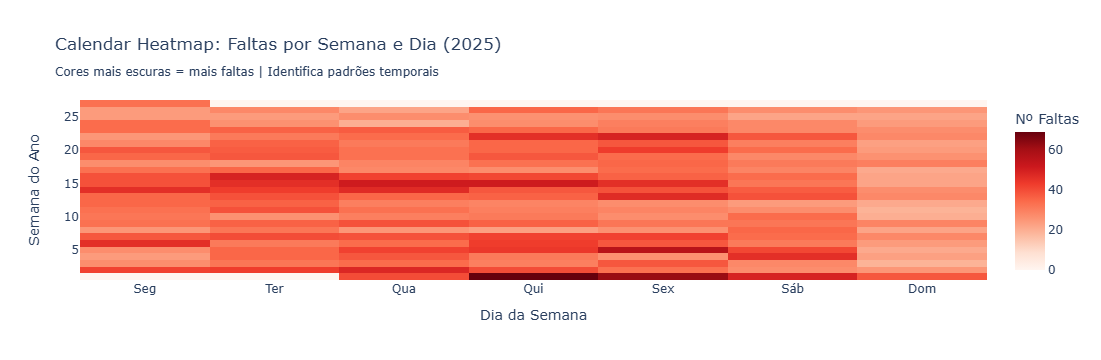


Estatísticas do Calendar Heatmap:
   Total de dias com faltas: 181
   Média de faltas por dia: 33.3
   Dia com mais faltas: 2025-01-02 (69 faltas)

Média de faltas por dia da semana:
   Seg: 32.9
   Ter: 35.1
   Qua: 34.7
   Qui: 36.6
   Sex: 36.8
   Sáb: 32.5
   Dom: 24.5

GRUPO 11 CONCLUÍDO

ANÁLISE COMPLETA FINALIZADA!


In [152]:
# Usar faltas de 2025
df_heatmap = df_faltas[df_faltas['Data'].dt.year == 2025].copy()

# Contar ausências por dia
ausencias_dia = df_heatmap.groupby('Data').size().reset_index(name='num_ausencias')

# Adicionar features
ausencias_dia['ano'] = ausencias_dia['Data'].dt.year
ausencias_dia['semana'] = ausencias_dia['Data'].dt.isocalendar().week
ausencias_dia['dia_semana'] = ausencias_dia['Data'].dt.dayofweek

# Pivot: semanas x dias da semana
pivot_calendar = ausencias_dia.pivot_table(
    index='semana',
    columns='dia_semana',
    values='num_ausencias',
    aggfunc='sum'
).fillna(0)

# Criar heatmap
fig_calendar = go.Figure(data=go.Heatmap(
    z=pivot_calendar.values,
    x=['Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'Sáb', 'Dom'],
    y=pivot_calendar.index,
    colorscale='Reds',
    colorbar=dict(title="Nº Faltas"),
    hoverongaps=False,
    hovertemplate='Semana %{y}<br>%{x}<br>Faltas: %{z}<extra></extra>'
))

fig_calendar.update_layout(
    title='Calendar Heatmap: Faltas por Semana e Dia (2025)<br><sub>Cores mais escuras = mais faltas | Identifica padrões temporais</sub>',
    xaxis_title='Dia da Semana',
    yaxis_title='Semana do Ano',
    height=700
)

fig_calendar.show()

# Estatísticas
print(f'\nEstatísticas do Calendar Heatmap:')
print(f'   Total de dias com faltas: {len(ausencias_dia)}')
print(f'   Média de faltas por dia: {ausencias_dia["num_ausencias"].mean():.1f}')
print(f'   Dia com mais faltas: {ausencias_dia.loc[ausencias_dia["num_ausencias"].idxmax(), "Data"].date()} ({ausencias_dia["num_ausencias"].max():.0f} faltas)')

# Análise por dia da semana
print(f'\nMédia de faltas por dia da semana:')
media_por_dia = ausencias_dia.groupby('dia_semana')['num_ausencias'].mean()
dias_nome = ['Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'Sáb', 'Dom']

for dia_num, dia_nome in enumerate(dias_nome):
    media = media_por_dia.get(dia_num, 0)
    print(f'   {dia_nome}: {media:.1f}')

print('\n' + '='*70)
print('GRUPO 11 CONCLUÍDO')
print('='*70)
print('\nANÁLISE COMPLETA FINALIZADA!')
print('='*70)

##  9. ANÁLISE DE REDES SOCIAIS

### 9.1 Análise de co-ocorrência de ausências 

Identificando pares de colaboradores que faltam no mesmo dia...

Pares de co-ausência identificados: 16,137
Pares com >= 3 co-ausências: 2144

Criando grafo de rede de co-ausências...


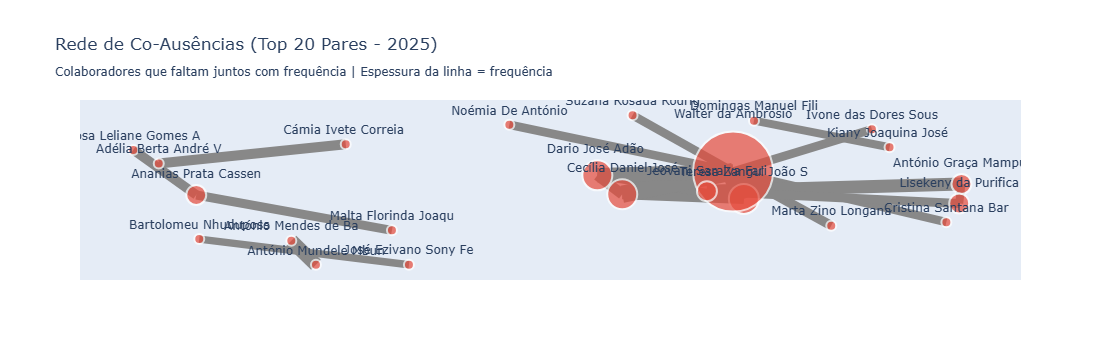


Estatísticas da rede:
   Nós (colaboradores): 23
   Arestas (conexões): 20
   Densidade da rede: 0.079

Top 5 pares com mais co-ausências:

Colaborador 1                    | Colaborador 2                    | Co-Ausências
------------------------------------------------------------------------------------------
Teresa Zangui João Simão       | Walter da Ambrósio             |           45
Cecília Daniel José            | Walter da Ambrósio             |           35
Dario José Adão                | Walter da Ambrósio             |           29
António Mendes de Barros Macha | António Mundele Mbunga         |           28
António Graça Mampuia Despinol | Jeovani Saraiva Faria da Costa |           26

GRUPO 9 CONCLUÍDO


In [156]:
# Usar faltas de 2025
df_rede = df_faltas[df_faltas['Data'].dt.year == 2025].copy()

# Criar pares de colaboradores que faltam no mesmo dia na mesma operação
if 'operacao' in df_rede.columns:
    print('Identificando pares de colaboradores que faltam no mesmo dia...')
    
    # Agrupar por data e operação
    df_rede_grouped = df_rede.groupby(['Data', 'operacao'])['login_colaborador'].apply(list).reset_index()
    
    # Criar pares (apenas se >= 2 colaboradores faltaram)
    pares_co_ausencia = []
    
    for _, row in df_rede_grouped.iterrows():
        colaboradores = row['login_colaborador']
        if len(colaboradores) >= 2:
            # Criar todos os pares possíveis
            for i in range(len(colaboradores)):
                for j in range(i+1, len(colaboradores)):
                    pares_co_ausencia.append({
                        'colab1': colaboradores[i],
                        'colab2': colaboradores[j],
                        'data': row['Data'],
                        'operacao': row['operacao']
                    })
    
    df_pares = pd.DataFrame(pares_co_ausencia)
    
    if len(df_pares) > 0:
        print(f'\nPares de co-ausência identificados: {len(df_pares):,}')
        
        # Contar frequência de cada par
        df_pares['par'] = df_pares.apply(
            lambda x: tuple(sorted([x['colab1'], x['colab2']])), 
            axis=1
        )
        
        frequencia_pares = df_pares['par'].value_counts().reset_index()
        frequencia_pares.columns = ['par', 'num_co_ausencias']
        
        # Filtrar pares com co-ausência significativa (>= 3 vezes)
        pares_frequentes = frequencia_pares[frequencia_pares['num_co_ausencias'] >= 3]
        
        print(f'Pares com >= 3 co-ausências: {len(pares_frequentes)}')
        
        if len(pares_frequentes) > 0:
            # Adicionar nomes
            login_to_nome = df_rede[['login_colaborador', 'nome_colaborador']].drop_duplicates().set_index('login_colaborador')['nome_colaborador'].to_dict()
            
            pares_frequentes['colab1'] = pares_frequentes['par'].apply(lambda x: x[0])
            pares_frequentes['colab2'] = pares_frequentes['par'].apply(lambda x: x[1])
            pares_frequentes['nome1'] = pares_frequentes['colab1'].map(login_to_nome)
            pares_frequentes['nome2'] = pares_frequentes['colab2'].map(login_to_nome)
            
            # Visualização: Network graph (top 20 pares)
            print('\nCriando grafo de rede de co-ausências...')
            
            import networkx as nx
            
            # Criar grafo
            G = nx.Graph()
            
            # Adicionar arestas (top 20 pares)
            top_pares = pares_frequentes.nlargest(20, 'num_co_ausencias')
            
            for _, row in top_pares.iterrows():
                G.add_edge(
                    row['nome1'][:20], 
                    row['nome2'][:20], 
                    weight=row['num_co_ausencias']
                )
            
            # Layout
            pos = nx.spring_layout(G, k=2, iterations=50)
            
            # Criar traces para plotly
            edge_trace = []
            for edge in G.edges(data=True):
                x0, y0 = pos[edge[0]]
                x1, y1 = pos[edge[1]]
                weight = edge[2]['weight']
                
                edge_trace.append(go.Scatter(
                    x=[x0, x1, None],
                    y=[y0, y1, None],
                    mode='lines',
                    line=dict(width=weight/2, color='#888'),
                    hoverinfo='none',
                    showlegend=False
                ))
            
            # Nodes
            node_x = [pos[node][0] for node in G.nodes()]
            node_y = [pos[node][1] for node in G.nodes()]
            node_text = list(G.nodes())
            node_size = [G.degree(node) * 10 for node in G.nodes()]
            
            node_trace = go.Scatter(
                x=node_x,
                y=node_y,
                mode='markers+text',
                text=node_text,
                textposition='top center',
                marker=dict(
                    size=node_size,
                    color='#e74c3c',
                    line=dict(width=2, color='white')
                ),
                hovertemplate='%{text}<extra></extra>'
            )
            
            # Figura
            fig_rede = go.Figure(data=edge_trace + [node_trace])
            
            fig_rede.update_layout(
                title='Rede de Co-Ausências (Top 20 Pares - 2025)<br><sub>Colaboradores que faltam juntos com frequência | Espessura da linha = frequência</sub>',
                showlegend=False,
                hovermode='closest',
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                height=700
            )
            
            fig_rede.show()
            
            # Estatísticas
            print(f'\nEstatísticas da rede:')
            print(f'   Nós (colaboradores): {G.number_of_nodes()}')
            print(f'   Arestas (conexões): {G.number_of_edges()}')
            
            if G.number_of_nodes() > 0:
                densidade = nx.density(G)
                print(f'   Densidade da rede: {densidade:.3f}')
            
            # Top 5 pares
            print(f'\nTop 5 pares com mais co-ausências:')
            print('\nColaborador 1                    | Colaborador 2                    | Co-Ausências')
            print('-' * 90)
            for _, row in pares_frequentes.nlargest(5, 'num_co_ausencias').iterrows():
                print(f'{row["nome1"][:30]:30s} | {row["nome2"][:30]:30s} | {row["num_co_ausencias"]:12.0f}')
        
        else:
            print('Não foram encontrados pares com co-ausência significativa (>= 3 vezes)')
    
    else:
        print('Nenhum par de co-ausência encontrado')

else:
    print('Campo "operacao" não encontrado. Análise de redes requer informação de operação.')

print('\n' + '='*70)
print('GRUPO 9 CONCLUÍDO')
print('='*70)